In [10]:
import sys
import numpy as np
import os
from os.path import abspath

import matplotlib.pyplot as plt
%matplotlib inline
import subtle.subtle_io as suio

# import subtle.subtle_preprocess as sup
import subtle.subtle_plot as suplot
import nibabel as nib
import nipype
from nipype.interfaces import fsl
import nipype.interfaces.io

from niwidgets import NiftiWidget
# NiftiWidget(_x0).nifti_plotter()

from IPython.display import Image
print(fsl.Info().version())


6.0.0


In [26]:
working_dir = '/raid/jon/data_full_stanford/data/Patient_0545'

In [29]:
nib_files = []
for filename in os.listdir(working_dir):
    if ".nii" in filename.lower():
        nib_files.append(os.path.join(working_dir,filename))
order = np.argsort([int(os.path.basename(l).split('_')[0]) for l in nib_files])
nib_files = list(np.array(nib_files)[order])
print(nib_files)

['/raid/jon/data_full_stanford/data/Patient_0545/7_ax_bravo_pre.nii.gz', '/raid/jon/data_full_stanford/data/Patient_0545/10_ax_bravo_c_pre_load_10.nii.gz', '/raid/jon/data_full_stanford/data/Patient_0545/14_ax_bravoc.nii.gz']


In [30]:
## brain extraction
frac = .5
robust = True
reduce_bias = False

bet_zero_node = nipype.Node(fsl.BET(frac=frac, reduce_bias=reduce_bias), name='bet_zero')
bet_low_node = nipype.Node(fsl.BET(frac=frac, reduce_bias=reduce_bias), name='bet_low')
bet_full_node = nipype.Node(fsl.BET(frac=frac, reduce_bias=reduce_bias), name='bet_full')

In [31]:
## coregistration on brain extraction
cost = 'corratio'
dof = 6
searchr_x = [-20, 20]
searchr_y = [-20, 20]
searchr_z = [-20, 20]
bins = 256
interp = 'trilinear'

coreg_low_node = nipype.Node(fsl.FLIRT(cost=cost, dof=dof, interp=interp, bins=bins, searchr_x=searchr_x, searchr_y=searchr_y, searchr_z=searchr_z),
                             name='coreg_low')
coreg_full_node = nipype.Node(fsl.FLIRT(cost=cost, dof=dof, interp=interp, bins=bins, searchr_x=searchr_x, searchr_y=searchr_y, searchr_z=searchr_z),
                             name='coreg_full')


In [121]:
from nipype.interfaces.base import BaseInterface, \
    BaseInterfaceInputSpec, traits, File, TraitedSpec
from nipype.utils.filemanip import split_filename

import nibabel as nb
import numpy as np
import os

class SimpleThresholdInputSpec(BaseInterfaceInputSpec):
    volume = File(exists=True, desc='volume to be thresholded', mandatory=True)
    threshold = traits.Float(desc='everything below this value will be set to zero',
                             mandatory=True)


class SimpleThresholdOutputSpec(TraitedSpec):
    thresholded_volume = File(exists=True, desc="thresholded volume")


class SimpleThreshold(BaseInterface):
    input_spec = SimpleThresholdInputSpec
    output_spec = SimpleThresholdOutputSpec

    def _run_interface(self, runtime):
        fname = self.inputs.volume
        img = nb.load(fname)
        data = np.array(img.get_data())

        active_map = data > self.inputs.threshold

        thresholded_map = np.zeros(data.shape)
        thresholded_map[active_map] = data[active_map]

        new_img = nb.Nifti1Image(thresholded_map, img.affine, img.header)
        _, base, _ = split_filename(fname)
        nb.save(new_img, base + '_thresholded.nii.gz')

        return runtime

    def _list_outputs(self):
        outputs = self._outputs().get()
        fname = self.inputs.volume
        _, base, _ = split_filename(fname)
        outputs["thresholded_volume"] = os.path.abspath(base + '_thresholded.nii.gz')
        return outputs

In [138]:
from nipype.interfaces.base import BaseInterface, \
    BaseInterfaceInputSpec, traits, File, TraitedSpec
from nipype.utils.filemanip import split_filename

import nibabel as nb
import numpy as np
import os

class MaskCombineInputSpec(BaseInterfaceInputSpec):
    in0 = File(exists=True, desc='input 0', mandatory=True)
    in1 = File(exists=True, desc='input 1', mandatory=True)
    in2 = File(exists=True, desc='input 2', mandatory=True)



class MaskCombineOutputSpec(TraitedSpec):
    out = File(exists=True, desc="mask")


class MaskCombine(BaseInterface):
    input_spec = MaskCombineInputSpec
    output_spec = MaskCombineOutputSpec

    def _run_interface(self, runtime):
        f0 = self.inputs.in0
        f1 = self.inputs.in1
        f2 = self.inputs.in2
        
        x0 = nb.load(f0)
        x1 = nb.load(f1)
        x2 = nb.load(f2)
        
        mask = ((x0.get_fdata()>0)+(x1.get_fdata()>0)+(x2.get_fdata()>0)) > 0

        out = nb.Nifti1Image(mask, x0.affine, x0.header)
        _, base, _ = split_filename(f0)
        nb.save(out, base + '_combined_mask.nii.gz')

        return runtime

    def _list_outputs(self):
        outputs = self._outputs().get()
        fname = self.inputs.in0
        _, base, _ = split_filename(fname)
        outputs["out"] = os.path.abspath(base + '_combined_mask.nii.gz')
        return outputs

In [145]:
from nipype.interfaces.base import BaseInterface, \
    BaseInterfaceInputSpec, traits, File, TraitedSpec
from nipype.utils.filemanip import split_filename

import nibabel as nb
import numpy as np
import os

class ApplyMaskInputSpec(BaseInterfaceInputSpec):
    input_file = File(exists=True, desc='input', mandatory=True)
    mask = File(exists=True, desc='mask', mandatory=True)



class ApplyMaskOutputSpec(TraitedSpec):
    out = File(exists=True, desc="masked image")


class ApplyMask(BaseInterface):
    input_spec = ApplyMaskInputSpec
    output_spec = ApplyMaskOutputSpec

    def _run_interface(self, runtime):
        f0 = self.inputs.input_file
        fm = self.inputs.mask
        
        x0 = nb.load(f0)
        xm = nb.load(fm)
        
        x_out = x0.get_fdata() * xm.get_fdata()
        
        out = nb.Nifti1Image(x_out, x0.affine, x0.header)
        _, base, _ = split_filename(f0)
        nb.save(out, base + '_masked.nii.gz')

        return runtime

    def _list_outputs(self):
        outputs = self._outputs().get()
        fname = self.inputs.input_file
        _, base, _ = split_filename(fname)
        outputs["out"] = os.path.abspath(base + '_masked.nii.gz')
        return outputs

In [146]:
# my_node3 = nipype.Node(SimpleThreshold(threshold=1001), name='testme')
my_node4 = nipype.Node(MaskCombine(), name='testme2')
my_node5 = nipype.Node(ApplyMask(), name='testme3')

190205-18:12:48,834 nipype.workflow INFO:
	 Generated workflow graph: /raid/jon/data_full_stanford/data/Patient_0545/registration/graph.png (graph2use=flat, simple_form=True).


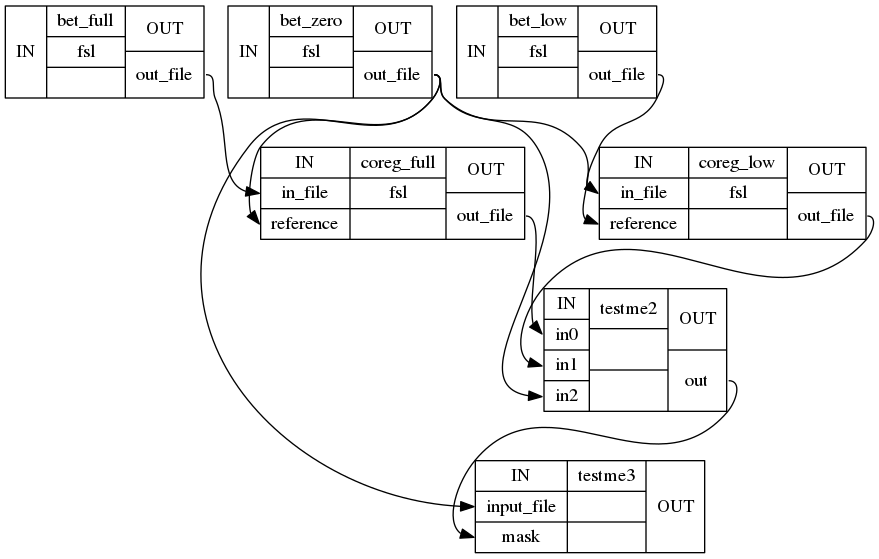

In [147]:
wf = nipype.Workflow(name='registration', base_dir=working_dir)
wf.connect([
    (bet_zero_node, coreg_low_node, [('out_file', 'reference')]), 
    (bet_low_node, coreg_low_node, [('out_file', 'in_file')]), 
    (bet_zero_node, coreg_full_node, [('out_file', 'reference')]), 
    (bet_full_node, coreg_full_node, [('out_file', 'in_file')]), 
#     (bet_zero_node, combine_masks_node, [('out_file', 'x0')]), 
#     (coreg_low_node, combine_masks_node, [('out_file', 'x1')]), 
#     (coreg_full_node, combine_masks_node, [('out_file', 'x2')]), 
    (coreg_full_node, my_node4, [('out_file', 'in0')]), 
    (coreg_low_node, my_node4, [('out_file', 'in1')]), 
    (bet_zero_node, my_node4, [('out_file', 'in2')]), 
    (bet_zero_node, my_node5, [('out_file', 'input_file')]), 
    (my_node4, my_node5, [('out', 'mask')]), 
           ])

# wf.write_graph('workflow_graph.dot')
# Image(filename='{working_dir}/registration/workflow_graph.png'.format(working_dir=working_dir))

wf.write_graph(graph2use='flat')
Image(filename='{working_dir}/registration/graph_detailed.png'.format(working_dir=working_dir))

In [148]:
bet_zero_node.inputs.in_file = nib_files[0]
bet_low_node.inputs.in_file = nib_files[1]
bet_full_node.inputs.in_file = nib_files[2]

# wf.run()
wf.run(plugin='MultiProc', plugin_args={'n_procs' : 10})

190205-18:12:53,220 nipype.workflow INFO:
	 Workflow registration settings: ['check', 'execution', 'logging', 'monitoring']
190205-18:12:53,231 nipype.workflow INFO:
	 Running in parallel.
190205-18:12:53,236 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 3 jobs ready. Free memory (GB): 226.65/226.65, Free processors: 10/10.
190205-18:12:53,387 nipype.workflow INFO:
	 [Job 0] Cached (registration.bet_full).
190205-18:12:53,390 nipype.workflow INFO:
	 [Job 1] Cached (registration.bet_low).
190205-18:12:53,393 nipype.workflow INFO:
	 [Job 2] Cached (registration.bet_zero).
190205-18:12:55,238 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 226.65/226.65, Free processors: 10/10.
190205-18:12:55,410 nipype.workflow INFO:
	 [Job 3] Cached (registration.coreg_full).
190205-18:12:55,414 nipype.workflow INFO:
	 [Job 4] Cached (registration.coreg_low).
190205-18:12:57,239 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Fr

In [149]:
print(working_dir)
!tree /raid/jon/data_full_stanford/data/Patient_0545 -I '*js|*json|*html|*pklz|_report'


/raid/jon/data_full_stanford/data/Patient_0545
/raid/jon/data_full_stanford/data/Patient_0545
├── 10_ax_bravo_c_pre_load_10.nii.gz
├── 14_ax_bravoc.nii.gz
├── 7_ax_bravo_pre.nii.gz
└── registration
    ├── bet_full
    │   ├── 14_ax_bravoc_brain.nii.gz
    │   └── command.txt
    ├── bet_low
    │   ├── 10_ax_bravo_c_pre_load_10_brain.nii.gz
    │   └── command.txt
    ├── bet_zero
    │   ├── 7_ax_bravo_pre_brain.nii.gz
    │   └── command.txt
    ├── coreg_full
    │   ├── 14_ax_bravoc_brain_flirt.nii.gz
    │   └── command.txt
    ├── coreg_low
    │   ├── 10_ax_bravo_c_pre_load_10_brain_flirt.nii.gz
    │   └── command.txt
    ├── graph_detailed.dot
    ├── graph_detailed.png
    ├── graph.dot
    ├── graph.png
    ├── testme
    │   └── 14_ax_bravoc_brain_flirt_thresholded.nii.gz
    ├── testme2
    │   └── 14_ax_bravoc_brain_flirt_combined_mask.nii.gz
    └── testme3
        └── 7_ax_bravo_pre_brain_masked.nii.gz

9 directories, 20 files


(512, 512, 352)


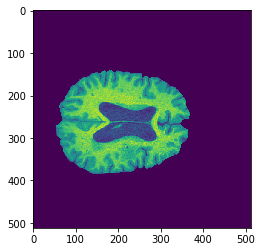

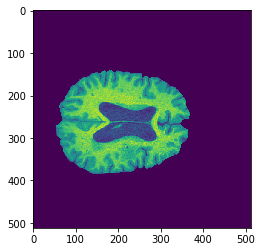

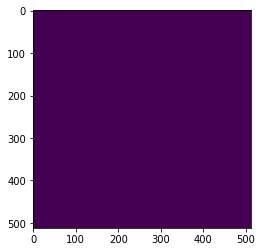

In [154]:
_tmp = nib.load('{}/registration/testme3/7_ax_bravo_pre_brain_masked.nii.gz'.format(working_dir))
_tmp2 = nib.load('{}/registration/bet_zero/7_ax_bravo_pre_brain.nii.gz'.format(working_dir))
tmp2 = _tmp2.get_fdata()
tmp = _tmp.get_fdata()
print(tmp.shape)
plt.imshow(tmp[...,idx])
plt.figure()
plt.imshow(tmp2[...,idx])
plt.figure()
plt.imshow((tmp-tmp2)[...,idx])


In [36]:
_x0 = nib.load('{}/registration/bet_zero/7_ax_bravo_pre_brain.nii.gz'.format(working_dir))
_x1 = nib.load('{}/registration/coreg_low/10_ax_bravo_c_pre_load_10_brain_flirt.nii.gz'.format(working_dir))
_x2 = nib.load('{}/registration/coreg_full/14_ax_bravoc_brain_flirt.nii.gz'.format(working_dir))
_x3 = nib.load('{}/registration/bet_full/14_ax_bravoc_brain.nii.gz'.format(working_dir))

x0, x1, x2, x3 = [__x.get_fdata() for __x in (_x0, _x1, _x2, _x3)]


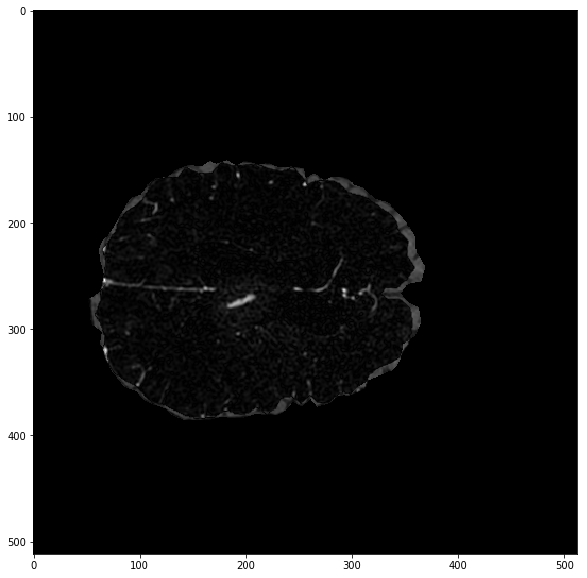

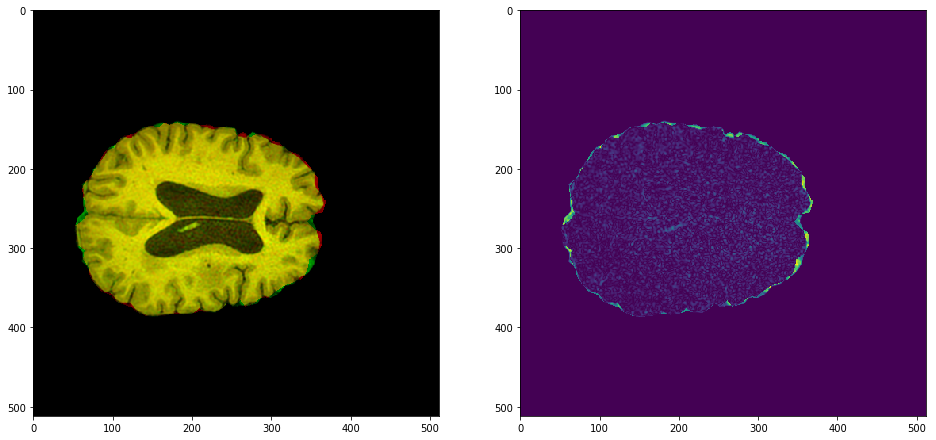

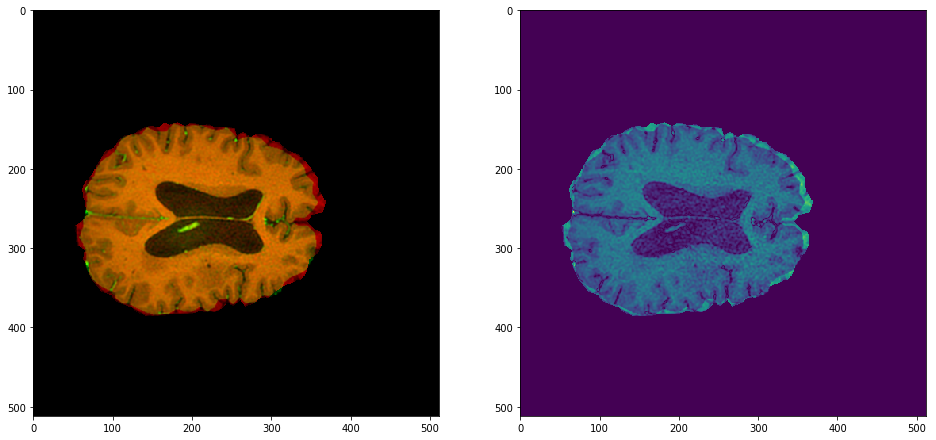

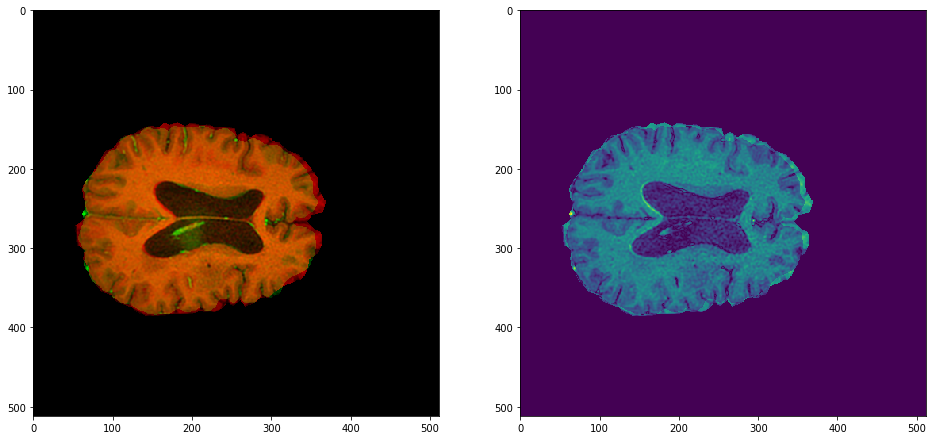

In [37]:
idx = 200

plt.figure(figsize=(16,10))
plt.imshow(abs(x2[...,idx] - x0[...,idx]), cmap='gray')

plt.figure(figsize=(16,10))
suplot.imshowreg(x0[...,idx], x1[...,idx])

plt.figure(figsize=(16,10))
suplot.imshowreg(x0[...,idx], x2[...,idx])

plt.figure(figsize=(16,10))
suplot.imshowreg(x0[...,idx], x3[..., idx])


## check if we can make single biggest brain mask

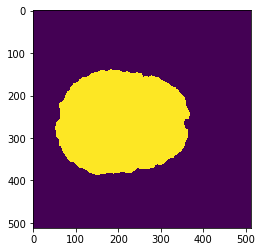

In [39]:
brain_mask = (x0+x1+x2) > 0
plt.imshow(brain_mask[...,idx])

## test kmeans to make enhancement mask 

In [41]:
from sklearn.cluster import KMeans

In [45]:
n = 6
idx_kmeans = np.arange(idx-20, idx+20)
X = np.stack((x0[...,idx_kmeans].ravel(), x1[...,idx_kmeans].ravel(), x2[...,idx_kmeans].ravel())).T
Xn = np.linalg.norm(X, axis=1)
print(X.shape)
X2 = X[Xn > 0.05*np.max(Xn)]
print(X2.shape)
kmeans = KMeans(n_clusters=n, random_state=723, n_jobs=10)
kmeans.fit(X2)

(10485760, 3)
(2425393, 3)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=10, precompute_distances='auto',
    random_state=723, tol=0.0001, verbose=0)

In [58]:
Y = kmeans.predict(X).reshape((x0[...,idx_kmeans].shape)).squeeze()
print(Y.shape)

(512, 512, 40)


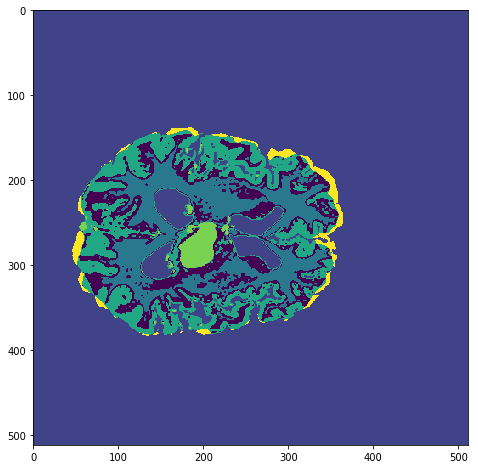

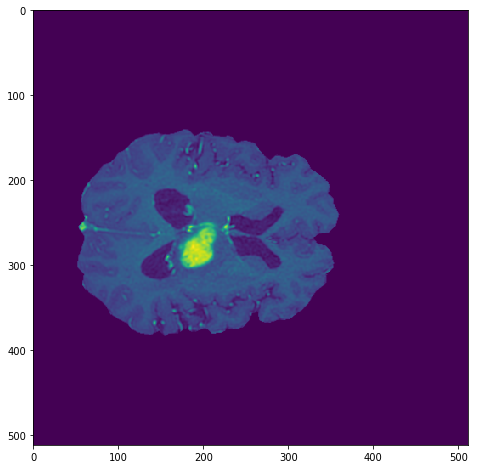

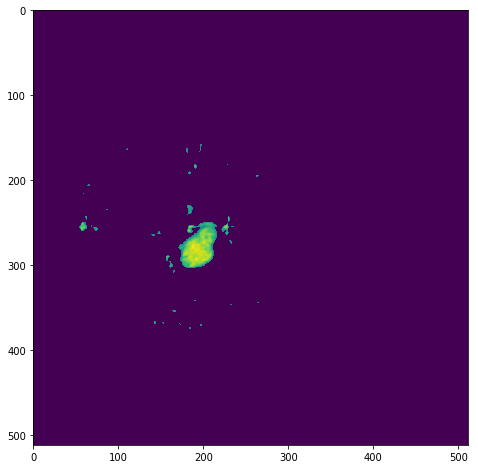

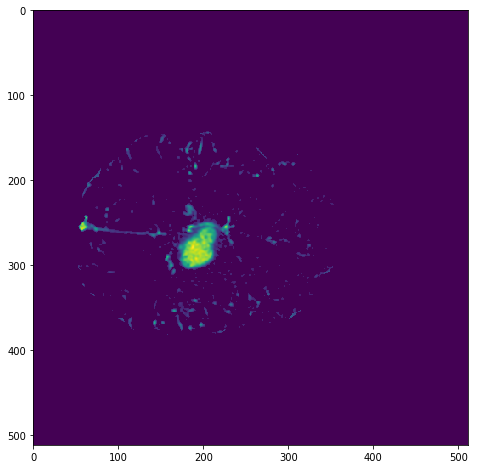

In [77]:
_idx = 0
plt.figure(figsize=(8,8))
plt.imshow(Y[...,_idx])
plt.figure(figsize=(8,8))
plt.imshow(x2[...,idx_kmeans[_idx]].squeeze())
plt.figure(figsize=(8,8))
plt.imshow(x2[...,idx_kmeans[_idx]].squeeze() * (Y[...,_idx]==4))

# it seems like it's simpler to threshold the difference image to get an enhancement mask
tmp = x2-x0
plt.figure(figsize=(8,8))
plt.imshow((tmp*(tmp > .05*np.max(abs(tmp))))[...,idx_kmeans[_idx]].squeeze())